# Credit Card Default Analysis
This notebook will be dedicated to analyzing credit card records from payments in Taiwan. The goal will be to create a model that will give the predictive accuracy of the probability of defaulting on a payment. 

This dataset is aimed at the case of customer default payments in Taiwan and compares the predictive accuracy of probability of default among data mining methods, with explanation of each step required to go from the imported data to data that can be used to classify defaults. For classification, I start by applying simple classification algorithms to the problem and assessing their accuracy using various measures, including accuracy, precision, recall, and a ROC curves, when needed. This will conclude the first portion of this project, as this will tell how accurate traditional methods of classification are when trying to predict credit card defaults.

From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. 

## Table of Contents
1. Data Wrangling and Explanations of Dataset Attributes
2. Data Story
3. Inferential Statistics
4. Basic Logistic Regression and Evaluation
5. GridsearchCV to Optimize l1 and l2 Logistic Regression, and Evaluation
6. Oversampling and Undersampling Methods on Logistic Regression, and Evaluation
7. Stratification of Sampling
8. Comparison to New Models

# 1. Data Wrangling and Explanations of Dataset Attributes
The data contain the following attributes:

## Attribute Information:

The research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. The study used the following 23 variables as explanatory variables: 
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- X2: Gender (1 = male; 2 = female). 
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = other). 
- X4: Marital status (1 = married; 2 = single; 3 = other). 
- X5: Age (year). 
- X6 - X11: History of past payment. They tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = duly paid; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
- X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. 
- X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005. 

I'll now load the appropriate packages for later use and load the dataset to begin cleaning and wrangling.

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from pandas.io.json import json_normalize
import seaborn as sns
from sklearn.metrics import roc_curve, auc, average_precision_score, precision_recall_curve
import scipy.stats as stats

In [4]:
defaults_df = pd.DataFrame.from_csv('default_of_credit_card_clients.csv')
defaults_df.shape

# Getting rid of first line mistake
new_header = defaults_df.iloc[0]
defaults_df = defaults_df[1:]
defaults_df.rename(columns = new_header)

#Renaming columns
new_header = list(new_header)
new_header[-1] = 'Y'
defaults_df.columns = new_header

# Changing to numeric
defaults_df = defaults_df.apply(pd.to_numeric)

# Removing false education values
defaults_df = defaults_df[defaults_df.EDUCATION != 0]

print(defaults_df.shape)
defaults_df.head()

(29986, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
# Check what are the data types of the numbers provided
print(type(defaults_df.SEX[0]))
print(type(defaults_df.AGE[0]))
print(type(defaults_df.BILL_AMT4[0]))

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


In [6]:
# Checking if any rows are blank.
defaults_df.shape[0] - defaults_df.dropna().shape[0]

0

In [7]:
# Missing/Null values?
defaults_df.isnull().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
Y            0
dtype: int64

After running some code to determine how much of the imported dataset was null or not, I found out that none of the columns had missing values. That doesn't mean there are no null values, it just means there are no values that I need to concern myself with, with regards to coverting from NULL or NaN to some logical value (average, median, regressed, etc.). 

## One-hot encoding
One-hot encoding is useful in python to train any type of model that contains categorical features. In this case, there are 9 different features that contain categorical values. Within those columns, there are varying options for distinction, such as sex having 2 options and history of past payment having 10 different values. One-hot encoding will split each of these columns into columns that have one category in the column, and whether or not that value is present in the row. Going back to the 'sex' category, this will split it into two columns called: "SEX_male" and "SEX_female", each of which will only contain binary variables.

To do this, I will use pandas to mutate the dataframe into something that is ready to use for ML algorithms.

In [8]:
clf_df = pd.get_dummies(defaults_df, columns=["SEX", "EDUCATION", "MARRIAGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"],
               prefix=["SEX", "EDU", "MARRY", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"])
clf_df.shape

(29986, 91)

Creted about 80 new columns that are permutations of all the unique values in the categorical columns.

In [9]:
# Finally, converting all values to numeric
clf_df = clf_df.apply(pd.to_numeric)

In [10]:
clf_df.dtypes.unique

<bound method Series.unique of LIMIT_BAL    int64
AGE          int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
Y            int64
SEX_1        uint8
SEX_2        uint8
EDU_1        uint8
EDU_2        uint8
EDU_3        uint8
EDU_4        uint8
EDU_5        uint8
EDU_6        uint8
MARRY_0      uint8
MARRY_1      uint8
MARRY_2      uint8
MARRY_3      uint8
PAY_0_-2     uint8
PAY_0_-1     uint8
PAY_0_0      uint8
             ...  
PAY_4_-1     uint8
PAY_4_0      uint8
PAY_4_1      uint8
PAY_4_2      uint8
PAY_4_3      uint8
PAY_4_4      uint8
PAY_4_5      uint8
PAY_4_6      uint8
PAY_4_7      uint8
PAY_4_8      uint8
PAY_5_-2     uint8
PAY_5_-1     uint8
PAY_5_0      uint8
PAY_5_2      uint8
PAY_5_3      uint8
PAY_5_4      uint8
PAY_5_5      uint8
PAY_5_6      uint8
PAY_5_7      uint8
PAY_5_8      uint8


# 2. Data Story
In 2006, Taiwan faced a credit crisis that came to a head in the third quarter of 2006. This all started with banks over-issuing cash and credit to unqualified applicants and was catalyzed by many cardholders, irrespective of their repayment ability, overusing their credit cards for consumption, accruing heavy credit and cash-card debts. This crisis warranted more thorough investigation into improved techniques for assessing the probability of default by each individual consumer.

In summary, there are 23 features of the dataset that can be explored to get a better understanding of the information provided. Some features are time-series related information, such as the history of past payment, amount of bill statement in NT dollars, and the amount of previous payments. These are abstract concepts and, while they may be informative on their own for a machine learning model, they are quite hard to understand as they are right now, seperated by columns for each individual. To rectify this issue, I will construct visualizations that show where the state of the Taiwan economy is from April to September of 2015, by each individual.

To do this, I'll construct a parallel coordinates graph for three sets of data: History of past payment (X6-X11), amount of bill statement (X12-X17), and amount of previous payment (X18-X23). Parallel coordinate graphs are especially useful for visualizing trends in clustered or labeled data, but since this dataset is on a continuous scale, I'll start by just observing overall trends.

In [11]:
# Loading relevant packages for data story
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
init_notebook_mode(connected=True)

You'll notice that I am using Plot.ly's graphing package for this job. While matplotlib, seaborn, d3.js, and other graphing packages are great, they have various limitations, including the ability to graph parallel coordinate plots, easily. While plotly can make some really stellar graphics, I've noticed that, when trying to share rendered images, that some variables can be mixed up between graphs (annoying) or that it doesn't render at all (also annoying). However, when it works, it looks great! Since you need to setup a plot.ly username and API key, I suggest trying to save your image to your plot.ly account and paste it whenever you need it.

Back to the data story. I'll start by creating 3 different dataframes for each time series variable: previous payment amount, previous bill amounts, and previous payment status. I'll start by plotting previous payment status, which is a categorical variable from -2 to 9, move to previous bill amounts, which is continuous, and end with previous payment amount, also continuous. Each of them will be plotted in sequential order, with the earliest date to the far left.

In [12]:
# Breaking the df into 3 separate dfs, because doing 23 dimensions would be nuts
df_pay_hist = defaults_df.loc[:,'PAY_0':'PAY_6']
print(list(df_pay_hist))
df_bill_amt = defaults_df.loc[:,'BILL_AMT1':'BILL_AMT6']
print(list(df_bill_amt))
df_prev_pay = defaults_df.loc[:,'PAY_AMT1':'PAY_AMT6']
print(list(df_prev_pay))

# Make an ID column. Just have color-coded from ID1-ID30000
df_pay_hist['index_col'] = df_pay_hist.index
df_bill_amt['index_col'] = df_bill_amt.index
df_prev_pay['index_col'] = df_prev_pay.index

['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

## Previous Payment Status
First, I am going to try and visualize the payment history of Taiwanese credit card users on a coordinate plot to try and see trends over time. Each x-axis tick has a date associated, so there is no confusion about the time for each x-axis tick. As a reminder, here is a list of what the attributes mean:
- X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = duly paid; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

In [13]:
# Experimenting with df_pay_hist

 
#tls.set_credentials_file(
 #       username="vdz1192", 
  #      api_key="U2mDsdBvPpOtMj7MCqcy")

# to get your credentials
#credentials = tls.get_credentials_file()
data = [
    go.Parcoords(
        line = dict(color = df_pay_hist['index_col'],
                   colorscale = 'Jet',
                   showscale = True,
                   reversescale = True,
                   cmin = 0,
                   cmax = 30000),
        dimensions = list([
            dict(range = [-2,9],
                 tickvals = [-2,-1,0,1,2,3,4,5,6,7,8,9],
                 label = 'PAY_6: April, 2005', values = df_pay_hist['PAY_6']),
            dict(range = [-2,9],
                 tickvals = [-2,-1,0,1,2,3,4,5,6,7,8,9],
                 visible = True,
                 label = 'PAY_5: May, 2005', values = df_pay_hist['PAY_5']),
            dict(range = [-2,9],
                 tickvals = [-2,-1,0,1,2,3,4,5,6,7,8,9],
                 label = 'PAY_4: June, 2005', values = df_pay_hist['PAY_4']),
            dict(range = [-2,9],
                 tickvals = [-2,-1,0,1,2,3,4,5,6,7,8,9],
                 label = 'PAY_3: July, 2005', values = df_pay_hist['PAY_3']),
            dict(range = [-2,9],
                 ticktext = ['-2','-1','0','1','2','3','4','5','6','7','8','9'],
                 tickvals = [-2,-1,0,1,2,3,4,5,6,7,8,9],
                 label = 'PAY_2: August, 2005', values = df_pay_hist['PAY_2']),
            dict(range = [-2,9],
                 label = 'PAY_0: September, 2005', values = df_pay_hist['PAY_0'])
        ])
    )
]

py.iplot(data, filename = 'parcoords-Pay')

Assessing the coordinate plot, we can see that the lines associated with each month and ID are too noisy to draw any serious inferences from the data. 

## Plotting Monthly Bill Amount
Next, I'll create a coordinate plot to examine the monthly bill rate for each customer in the dataset. This will be a messy representation, but I'm just looking for general trends. Here are what the variables mean.
- X12-X17: Amount of bill statement (NT dollar)

In [14]:
data = [
    go.Parcoords(
        line = dict(color = df_bill_amt['index_col'],
                   colorscale = 'Jet',
                   showscale = True,
                   reversescale = True,
                   cmin = 0,
                   cmax = 30000),
        dimensions = list([
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT6: April, 2005', values = df_bill_amt['BILL_AMT6']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT5: May, 2005', values = df_bill_amt['BILL_AMT5']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT4: June, 2005', values = df_bill_amt['BILL_AMT4']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT3: July, 2005', values = df_bill_amt['BILL_AMT3']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT2: August, 2005', values = df_bill_amt['BILL_AMT2']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT1: September, 2005', values = df_bill_amt['BILL_AMT1'])
            
        ])
    )
]

py.iplot(data, filename = 'bill-amt')

This is interesting. We can see that the general trend of debt accrual is increasing over time. In addition, the variance is increasing. The red line is an intersting customer that likes to accrue debt, but overall there are no distinguishing trends within this dataset other than increasing mean and variance of debt. However, not much can be said about this plot, as there is too much noise within the data.

## Plotting Monthly Payments
We've seen the amount of debt for all of the customers, now let's look at how much they pay each month. This is in the same scale range as the bill amount.
- X18-X23: Amount of previous payment (NT dollar)

In [15]:
data = [
    go.Parcoords(
        line = dict(color = df_prev_pay['index_col'],
                   colorscale = 'Jet',
                   showscale = True,
                   reversescale = True,
                   cmin = 0,
                   cmax = 30000),
        dimensions = list([
            dict(range = [-200000,1000000],
                 label = 'PAY_AMT6: April, 2005', values = df_prev_pay['PAY_AMT6']),
            dict(range = [-200000,1000000],
                 label = 'PAY_AMT5: May, 2005', values = df_prev_pay['PAY_AMT5']),
            dict(range = [-200000,1000000],
                 label = 'PAY_AMT4: June, 2005', values = df_prev_pay['PAY_AMT4']),
            dict(range = [-200000,1000000],
                 label = 'PAY_AMT3: July, 2005', values = df_prev_pay['PAY_AMT3']),
            dict(range = [-200000,1000000],
                 label = 'PAY_AMT2: August, 2005', values = df_prev_pay['PAY_AMT2']),
            dict(range = [-200000,1000000],
                 label = 'PAY_AMT1: September, 2005', values = df_prev_pay['PAY_AMT1'])
            
        ])
    )
]

py.iplot(data, filename = 'prev-Pay')

There is a clear trend of triangles here. Triangles in a coordinate plot just represent a cylclical process over time. We can see that the vast majority make small payments less than 200k NT Dollars. Sometimes people make large payments, but then they return to a low steady-state of payments. I wonder what this means in terms of economic behavior of the customers? Why pay a large sum one month, wait, then pay another large sum?

## Plotting Sub-Ranges of Bill Amounts
We know that many Taiwanese people owe a lot of money. However, what does the bill distribution look like over time for people who had between 0-100k NT Dollars in April, 2005? What about the group with 100k-200k in debt in April of that year?

In [16]:
# Plotting the credit card holders who had 0-100,000 in debt.
data = [
    go.Parcoords(
        line = dict(color = df_bill_amt['index_col'],
                   colorscale = 'Jet',
                   showscale = True,
                   reversescale = True,
                   cmin = 0,
                   cmax = 30000),
        dimensions = list([
            dict(range = [-200000,1000000],
                 constraintrange = [0,100000],
                 label = 'BILL_AMT6: April, 2005', values = df_bill_amt['BILL_AMT6']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT5: May, 2005', values = df_bill_amt['BILL_AMT5']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT4: June, 2005', values = df_bill_amt['BILL_AMT4']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT3: July, 2005', values = df_bill_amt['BILL_AMT3']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT2: August, 2005', values = df_bill_amt['BILL_AMT2']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT1: September, 2005', values = df_bill_amt['BILL_AMT1'])
            
        ])
    )
]

py.iplot(data, filename = 'bill-amt')

In [17]:
# Plotting the credit card holders who had 100,000-200,000 in debt.
data = [
    go.Parcoords(
        line = dict(color = df_bill_amt['index_col'],
                   colorscale = 'Jet',
                   showscale = True,
                   reversescale = True,
                   cmin = 0,
                   cmax = 30000),
        dimensions = list([
            dict(range = [-200000,1000000],
                 constraintrange = [100000, 200000],
                 label = 'BILL_AMT6: April, 2005', values = df_bill_amt['BILL_AMT6']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT5: May, 2005', values = df_bill_amt['BILL_AMT5']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT4: June, 2005', values = df_bill_amt['BILL_AMT4']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT3: July, 2005', values = df_bill_amt['BILL_AMT3']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT2: August, 2005', values = df_bill_amt['BILL_AMT2']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT1: September, 2005', values = df_bill_amt['BILL_AMT1'])
            
        ])
    )
]

py.iplot(data, filename = 'bill-amt')

## Parallel Coordinate Summary
- The bill amount seems fairly steady over time, with a slight increase in average debt and increase in the variance of debt. 
- The payments fluctuate each month, with the average being below the average payments. Also, note how cyclical the payments are. It's almost as if the consumer saves more one month, then pays off the bill, then saves, then pays, and so on. 
- The last two plots are the parallel coordinate plots for customers who started with 0-100k and 100k-200k NT Dollars of debt. These graphs show a gradual creep upwards and away from the starting average debt, something that was more significant with the 0-100k range of values. Each coordinate plot showed an increase in the variance in the amount of debt.

Usually, parallel coordinate plots work better whenever there are groups and you want to see how those groups interact. For example, using Fisher's iris flower dataset to observe the changes between variables. Here, I arbitrarly grouped some users who I thought would be more responsible with payments, people with debt between 0-100k NT Dollars, and found that even here, they accumulated debt.  I then graphed 100k-200k NT Dollars and saw a similar trend. Had I chosen a monther earlier or later, it could have been a totally different group of people. Point is, everything is arbitrary here, and grouping by time series amounts is not a good path. However, it's still interesting to note the tendency for the mean and variance to increase for each subset of the population.

## Scatter Plots: Among Independent and Dependent Variables
Since we have seen the time series portion of this dataset, let's now focus on assessing correlation between independent and dependent variables. To do this, I'll create a correlation matrix among the non-time series related variables and the dependent outcome, defaulting on the next payment.

   LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  Y
1      20000    2          2         1   24  1
2     120000    2          2         2   26  1
3      90000    2          2         2   34  0
4      50000    2          2         1   37  0
5      50000    1          2         1   57  0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116fd0e48>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11884a898>]], dtype=object)

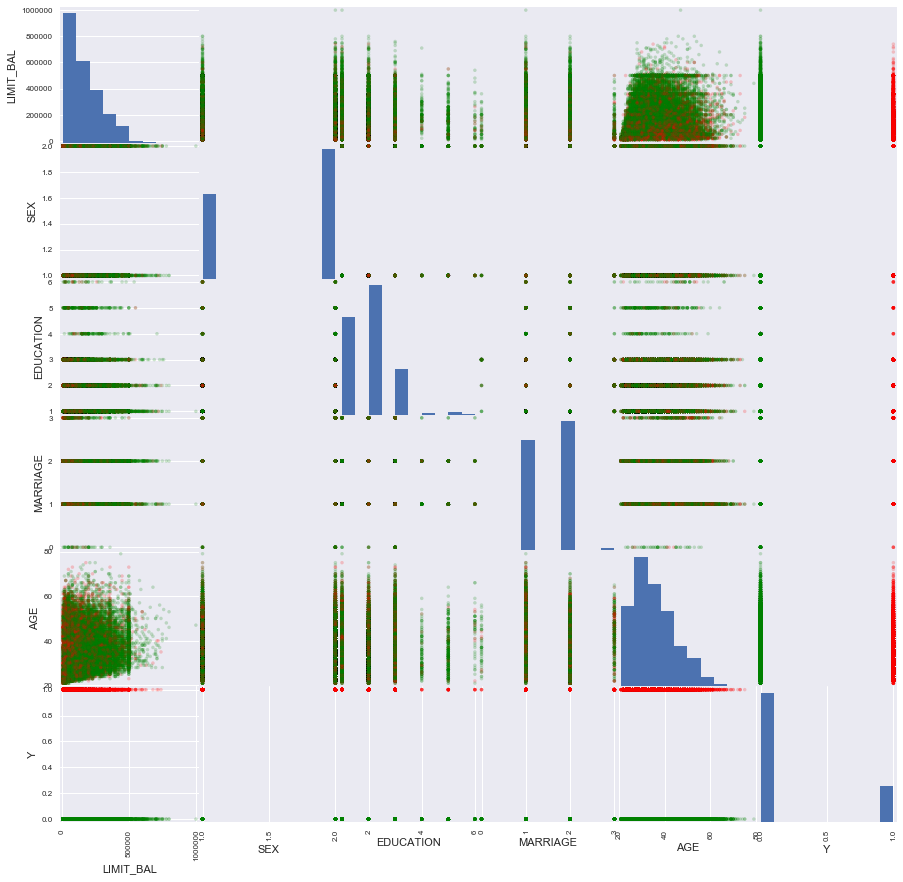

In [18]:
from pandas.plotting import scatter_matrix
# Create new matrix of isolated variables to plot
scatter_df = defaults_df[['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE','Y']]
scatter_df = scatter_df.apply(pd.to_numeric)
# define colors list, to be used to plot survived either red (=1) or green (=0)
colors=['green','red']
print(scatter_df.head())
scatter_matrix(scatter_df, alpha=0.2, figsize=(15,15), c=scatter_df.Y.apply(lambda x:colors[x]))

These scatter plots are rather noisy and not really formatted to display information that well. I have looked for a 'jitter' option within pandas plotting to allow for the density of the points to be displayed, rather than just a single point. For example, we cannot infer anything about the relation between education and defaulting with the current information, as each dot is superimposed over another, distorting any information that might be relayed easily here. As well, it would be nice for the categories to have space around the edges so that readers don't confuse categories and their distributions. I know how to do this in ggplot for R, but am still relatively new to plotting in Python, so I'll experiment with packages to achieve these goals later.

For now, I'll plot a correlation matrix to see if we might have any confounding independent variables.

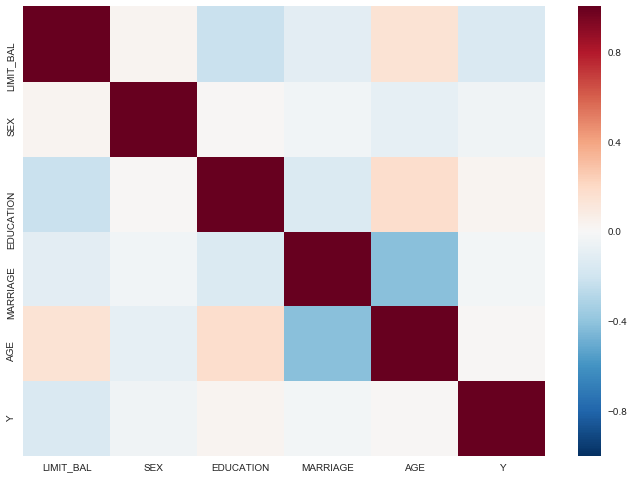

In [19]:
# calculate the correlation matrix
corr = scatter_df.corr()

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
# plot the heatmap
sns.heatmap(corr, ax=ax)

None of the variables are very strongly correlated, but this dataset also contains a plethora of categorical variables. Usually, tables or other discrete metrics are better at observing correlated categorical data, but I will forego this step in favor of plotting education against the dependent variable.

## Education and Defaults
This last part of the data story will look at how education plays a chance in defaults. I chose education as it very generally categorizes people across age, gender, and marriage status.

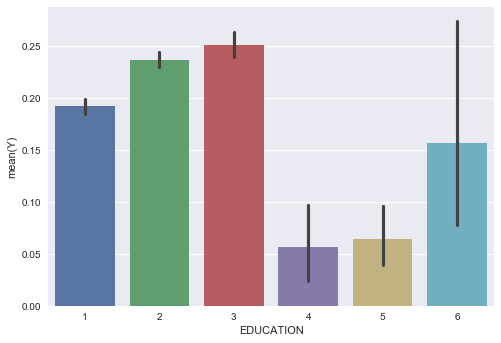

In [20]:
sns.barplot(x="EDUCATION", y="Y", data=scatter_df)

Looks like the mean amount of defaults is higher for education level 3. This bar chart does not account for the samples size of each of these subsets of the population. While I could make more visualizations that portray the rate of default as a function of sample size, education, gender, or marital status, this doesn't provide a satisfying answer about a quantifiable difference. 

# Data Story Conclusion
We've used coordinate plots extensively to see time series relationships of Taiwan credit card customers' debt and payment histories. From these graphical representations, we were able to see that the average debt was increasing while average payment was low and cyclical. 

If we were to use time series analysis to understand this trend and how much debt each person would have in a month, I believe there would be too much noise and variability among customers to accurately do this. Instead, I will resort to creating classification algorithms that take each variable and category into account for a model that can classify to a degree of accuracy whether a person will default in October of 2005. The next thing will be to create a model that predicts the probability of each person defaulting on their next payment.

# 3. Inferential Statistics of Taiwan Credit Users
So far, we have cleaned and assessed the data within the Taiwan Credit dataset. We examined the data for fatal flaws as well as trends among all of the customers, discovering the data was relatively clean enough to use to create a prediction model and that there were interesting trends in credit user behavior over time. Now I'll use some summary statistics to test some hypotheses among certain groups of interests.

I will focus on education level and start by using an ANOVA-type of analysis of the education level to the rate of default. To do this, I will need to use a Chi-Square test to test for significant difference between groups. I will then look to see if there is a statistical difference between certain groups. For the problem at hand, testing whether education level makes a difference in the rate of defaulting on debt payments. 

## Chi-Square Tests
To see whether education level makes a difference in the rate of defaults, I will test the null hypothesis that every education group has an equal rate of defaulting on their next payment. I chose to use a Chi-square test because of its ability to deal with data binned into proportions. The basic premise of the Chi-square test is to test the difference between expected and observed values, and if that difference translates into a Chi-square statistic that is statistically significant.

In [21]:
# Chi-square
# Create the contingency table
edu_default = pd.crosstab(index=scatter_df["EDUCATION"], 
                           columns=scatter_df["Y"])
edu_default.index= ["graduate","university","secondary","other","5","6"]
chi2, p, dof, ex = stats.chi2_contingency(edu_default)
print(chi2)
print(p)

159.185125405
1.4764557605e-32


With a p-value of 1.4x10^-32, we can see that there must be a difference between groups. I included in the original analysis the outlier numbers, 5 and 6, that do not have an explanation and have very small sample sizes. I will remove them to make a more accurate assessment of the p-value between education classes provided.

In [22]:
stats_df = scatter_df[(scatter_df.EDUCATION != 5) & (scatter_df.EDUCATION != 6)]
edu_default = pd.crosstab(index=stats_df["EDUCATION"], 
                           columns=stats_df["Y"])
edu_default.index= ["graduate","university","secondary","other"]
chi2, p, dof, ex = stats.chi2_contingency(edu_default)
print(chi2)
print(p)

116.859911535
3.66129962956e-25


There is still significance. Good, that means we can reject the null hyptohesis that a difference in default rate among educational groups is due to random chance. From the bar chart, it looks like the first three classes of education are relatively similar in their rates of default. Let's perform a Chi-square test on those three variables to see if there is statistical difference among them.

In [23]:
educated_df = scatter_df[(scatter_df.EDUCATION != 5) & (scatter_df.EDUCATION != 6) & (scatter_df.EDUCATION != 4)]
edu2_default = pd.crosstab(index=educated_df["EDUCATION"], 
                           columns=educated_df["Y"])
edu2_default.index= ["graduate","university","secondary"]
chi2, p, dof, ex = stats.chi2_contingency(edu_default)
print(chi2)
print(p)

116.859911535
3.66129962956e-25


They are still significantly different. A little obvious from the error bars on the proportions in the bar chart. Instead of comparing each education class individually, I'll simply calculate the 95% Confidence Interval (CI) for each class of educated people. Using the CI calculations, we can see if there is any overlap between the classes.

In [24]:
graduate_df = scatter_df[scatter_df.EDUCATION == 1]
college_df = scatter_df[scatter_df.EDUCATION == 2]
secondary_df = scatter_df[scatter_df.EDUCATION == 3]
other_df = scatter_df[scatter_df.EDUCATION == 4]
edu_default

Y,0,1
graduate,8549,2036
university,10700,3330
secondary,3680,1237
other,116,7


In [25]:
# odds of default for each education group
grad_def_odds = 2036/8549
univer_def_odds = 3330/107000
second_def_odds = 1237/3680
other_def_odds = 7/116

# Odds Ratios between groups
grad_uni_OR = grad_def_odds/univer_def_odds
grad_second_OR = grad_def_odds/second_def_odds
grad_other_OR = grad_def_odds/other_def_odds
uni_second_OR = univer_def_odds/second_def_odds
uni_other_OR = univer_def_odds/other_def_odds
second_other_OR = second_def_odds/other_def_odds

# SE for each OR
SE_grad_uni = np.sqrt((1/edu_default.iloc[0,0]) + (1/edu_default.iloc[0,1]) + (1/edu_default.iloc[1,0]) + (1/edu_default.iloc[1,1]))
SE_grad_second = np.sqrt((1/edu_default.iloc[0,0]) + (1/edu_default.iloc[0,1]) + (1/edu_default.iloc[2,0]) + (1/edu_default.iloc[2,1]))
SE_grad_other = np.sqrt((1/edu_default.iloc[0,0]) + (1/edu_default.iloc[0,1]) + (1/edu_default.iloc[3,0]) + (1/edu_default.iloc[3,1]))
SE_uni_second = np.sqrt((1/edu_default.iloc[1,0]) + (1/edu_default.iloc[1,1]) + (1/edu_default.iloc[2,0]) + (1/edu_default.iloc[2,1]))
SE_uni_other = np.sqrt((1/edu_default.iloc[1,0]) + (1/edu_default.iloc[1,1]) + (1/edu_default.iloc[3,0]) + (1/edu_default.iloc[3,1]))
SE_second_other = np.sqrt((1/edu_default.iloc[2,0]) + (1/edu_default.iloc[2,1]) + (1/edu_default.iloc[3,0]) + (1/edu_default.iloc[3,1]))

# 95% CI for each OR
grad_uni_CI_Lower = np.exp(np.log(grad_uni_OR) - 1.96*SE_grad_uni)
grad_uni_CI_Upper = np.exp(np.log(grad_uni_OR) + 1.96*SE_grad_uni)
print('Graduate and University log OR CI:', grad_uni_CI_Lower, grad_uni_CI_Upper)
print('')
grad_second_CI_Lower = np.exp(np.log(grad_second_OR) - 1.96*SE_grad_second)
grad_second_CI_Upper = np.exp(np.log(grad_second_OR) + 1.96*SE_grad_second)
print('Graduate and Secondary log OR CI:', grad_second_CI_Lower, grad_second_CI_Upper)
print('')
grad_other_CI_Lower = np.exp(np.log(grad_other_OR) - 1.96*SE_grad_other)
grad_other_CI_Upper = np.exp(np.log(grad_other_OR) + 1.96*SE_grad_other)
print('Graduate and Other log OR CI:', grad_other_CI_Lower, grad_other_CI_Upper)
print('')
uni_second_CI_Lower = np.exp(np.log(uni_second_OR) - 1.96*SE_uni_second)
uni_second_CI_Upper = np.exp(np.log(uni_second_OR) + 1.96*SE_uni_second)
print('University and Secondary log OR CI:', uni_second_CI_Lower, uni_second_CI_Upper)
print('')
uni_other_CI_Lower = np.exp(np.log(uni_other_OR) - 1.96*SE_uni_other)
uni_other_CI_Upper = np.exp(np.log(uni_other_OR) + 1.96*SE_uni_other)
print('University and Other log OR CI:', uni_other_CI_Lower, uni_other_CI_Upper)
print('')
second_other_CI_Lower = np.exp(np.log(second_other_OR) - 1.96*SE_second_other)
second_other_CI_Upper = np.exp(np.log(second_other_OR) + 1.96*SE_second_other)
print('Secondary and Other log OR CI:', second_other_CI_Lower, second_other_CI_Upper)
print("")

Graduate and University log OR CI: 7.19214977405 8.14226585777

Graduate and Secondary log OR CI: 0.65367999971 0.76791995631

Graduate and Other log OR CI: 1.83765094096 8.47582127284

University and Secondary log OR CI: 0.0858734868565 0.0998201118424

University and Other log OR CI: 0.240267517214 1.10699522971

Secondary and Other log OR CI: 2.59064383314 11.9772179062



## Odds Ratio Analysis
Besides the association between university and secondary educated customers, the log odds ratio indicate that many of the compared groups have highly different rates of default. 

A reminder about log(OR):
- Negative values are in preference of the denominator value (the second value here)
- Applying the exponential function (euler's number to the number provided) gives the CI of the odds ratio

The only indistiguishable groups are the university and secondary groups, each very much more likely to default than graduate level students.

# 4. Basic Logistic Regression and Evaluation
I'll begin building a classification model of whether a customer will default on their next payment or not by building a logistic regression model using default settings from sklearn. Once trained, I will test its accuracy, precision, and recall measurements. Recall will be the most important metric for this problem since the dataset is imbalanced, since most (about 70%) of the results are from the '0', non-default, class. Recall, or the true positive rate, will be the most important metric to adjust, since the damage done to credit card companies is most severe from not predicting customers who will default and the damage done by predicting a false positive is annoying to the customer, but much less severe in terms of consequences.

Now, to train a logistic regression model with default parameters.

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Split the data into a training and test set - 25% is testing
Xtrain, Xtest, ytrain, ytest = train_test_split(clf_df.drop('Y', axis=1),
                                                clf_df.Y, test_size=0.25, random_state=5,
                                                stratify = clf_df.Y)
clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(Xtrain, ytrain)
# Print the accuracy and recall from the testing data. Table values.
print(accuracy_score(clf.predict(Xtest), ytest))
target_names = ['0', '1']
print(classification_report(ytest, clf.predict(Xtest), target_names=target_names))

0.778578097906
             precision    recall  f1-score   support

          0       0.78      1.00      0.88      5838
          1       0.00      0.00      0.00      1659

avg / total       0.61      0.78      0.68      7497



We could look at the accuracy and think that 78% is not terrible, a decent start, but reviewing recall shows a large discrepancy between precition of the non-default and default classes. What the default model did was train to maximize accuracy, and by predicting all of the 0-class correctly did pretty well. However, this completely misses the problem of predicting customers who will default, as is indicated by a recall score of 0 for the default class.

Before I move on to techniques to deal with imbalanced data, I'll try and tune the hyperparameters for both l1 and l2 logistic regression before moving on.

## ## 5. GridsearchCV to Optimize l1 and l2 Logistic Regression And Evaluation
Will use GridsearchCV from sklearn to find the optimal values of the 'lambda' (C for GridsearchCV) hyperparameter for regularized logistic regression. Sklearn's GridsearchCV is able to search for the optimal hyperparameters for both L1 and L2 logistic regression. My expectation is that L2 regression will work better than L1 regularization, as L1 typically works better for data that is sparse, which is not the case from our data, as I could tell from the inferential statistics performed on the data.

I will be optimizing the parameters against accuracy and recall, of which I expect each optimal value to be different.

In [62]:
from sklearn.model_selection import GridSearchCV
parameters_l1 = {'penalty':['l1'], 'C': np.logspace(-4, 2, 30)}
parameters_l2 = {'penalty':['l2'], 'C': np.logspace(-4, 2, 30)}

scores = ['accuracy', 'recall']

logit_lambda = np.logspace(-4, 2, 30)  # Since lambda is a python function, don't call variable lambda
Penalty = ['l1', 'l2']

clf1 = LogisticRegression() # Do not change this.

for score in scores:
    print("# Tuning hyper-parameters for l1 %s" % score)
    print("")
    clf_opt = GridSearchCV(clf1, parameters_l1, cv=5, 
                           scoring=score)
    clf_opt.fit(Xtrain, ytrain)
    print(clf_opt.best_estimator_, "\n",
          clf_opt.best_params_, "\n",
          clf_opt.best_score_)
    print("")
    print("# Tuning hyper-parameters for l2 %s" % score)
    print("")
    clf_opt = GridSearchCV(clf1, parameters_l2, cv=5, 
                           scoring=score)
    clf_opt.fit(Xtrain, ytrain)
    print(clf_opt.best_estimator_, "\n",
          clf_opt.best_params_, "\n",
          clf_opt.best_score_)

# Tuning hyper-parameters for l1 accuracy

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
 {'C': 100.0, 'penalty': 'l1'} 
 0.820356618791

# Tuning hyper-parameters for l2 accuracy

LogisticRegression(C=0.00025929437974046669, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 
 {'C': 0.00025929437974046669, 'penalty': 'l2'} 
 0.778513940149
# Tuning hyper-parameters for l1 recall

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='li

We now have the optimal gridsearchCV parameters. What are their respective accuracy and recall scores?

In [74]:
clf_opt_recall_L1 = LogisticRegression(penalty='l1', C=1.3738237958832638) 
clf_opt_accuracy_L1 = LogisticRegression(penalty='l1', C=2.2122162910704501) 

clf_opt_recall_L2 = LogisticRegression(penalty='l2', C=0.20433597178569) 
clf_opt_accuracy_L2 = LogisticRegression(penalty='l2', C=0.0001) 

#Fitting the models
clf_opt_recall_L1.fit(Xtrain, ytrain)
clf_opt_recall_L2.fit(Xtrain, ytrain)

clf_opt_accuracy_L1.fit(Xtrain, ytrain)
clf_opt_accuracy_L2.fit(Xtrain, ytrain)

print('Optimized L1 precision-recall scores')
print('')
print('Optimized Recall')
print(classification_report(ytest, clf_opt_recall_L1.fit(Xtrain, ytrain).predict(Xtest), target_names=target_names))
print('Optimized Accuracy')
print(classification_report(ytest, clf_opt_accuracy_L1.fit(Xtrain, ytrain).predict(Xtest), target_names=target_names))
print('')
print('Optimized L2 precision-recall scores')
print('')
print('Optimized Recall')
print(classification_report(ytest, clf_opt_recall_L2.fit(Xtrain, ytrain).predict(Xtest), target_names=target_names))
print('Optimized Accuracy')
print(classification_report(ytest, clf_opt_accuracy_L2.fit(Xtrain, ytrain).predict(Xtest), target_names=target_names))

Optimized L1 precision-recall scores

Optimized Recall
             precision    recall  f1-score   support

          0       0.84      0.96      0.89      5838
          1       0.70      0.34      0.46      1659

avg / total       0.81      0.82      0.80      7497

Optimized Accuracy
             precision    recall  f1-score   support

          0       0.84      0.96      0.89      5838
          1       0.70      0.34      0.46      1659

avg / total       0.81      0.82      0.80      7497


Optimized L2 precision-recall scores

Optimized Recall
             precision    recall  f1-score   support

          0       0.78      1.00      0.88      5838
          1       0.00      0.00      0.00      1659

avg / total       0.61      0.78      0.68      7497

Optimized Accuracy
             precision    recall  f1-score   support

          0       0.78      1.00      0.88      5838
          1       0.00      0.00      0.00      1659

avg / total       0.61      0.78      0.68   

We can see that, while there is a difference in the optimal values for accuracy and recall, the parameter values differ by less than a thousandth (mean recall=0.35915 for lambda=1.3738 and mean recall=0.35975 for lambda=2.212). The bigger difference here is between L1 and L2 regularization, of which, L1 performed much better than L2. Even when optimized for recall, L2 was not able to return a satisfactory result.

# 6. Resampling: Oversampling and Undersampling Methods on Logistic Regression
There is an imbalance in the dataset that cannot be solved by simply optimizing the penalty parameters of l1-logistic regression. Instead, I will need to either under-sample or over-sample the dataset to balance the two. According to the rules of thumb listed below, I can choose from under-sampling or over-sampling to balance the dataset. I can do both and compare their Accuracy and precision-recall metric in order to determine which method improves the model the most. Additionally, I will experiment with random and non-random sampling schemes for over-sampling and under-sampling.

Some Rules of Thumb:

- Consider under-sampling when you have an a lot data (tens- or hundreds of thousands of instances or more)

- Consider over-sampling when you don’t have a lot of data (tens of thousands of records or less)

- Consider random and non-random (e.g. stratified) sampling schemes.

- Consider different resampled ratios (e.g. you don’t have to target a 1:1 ratio in a binary classification problem, try other ratios)

I will oversample the undersampled dataset until there are equal amounts of data for the positive and negative case of credit card default. To oversample I will use the imblearn SMOTE algorithm that oversamples by the following procedure:

- Finding the k-nearest-neighbors for minority class observations (finding similar observations)

- Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observation.

Since the SMOTE algorithm is performing some semi-complex resampling methods that involve KNN computations, I do not want that process to influence my test set, which is still a representative of the dataset as a whole. I will use the remaining training dataset to perform upsampling and preserve a validation set for which I can test the upsampled algorithms against.

In [64]:
from imblearn.under_sampling import RandomUnderSampler
# Reminder: Xtrain, Xtest, ytrain, ytest

# Undersampling with imblearn
rus = RandomUnderSampler(random_state = 12, ratio=1.0)
x_train_rus, y_train_rus = rus.fit_sample(Xtrain, ytrain)

# GridsearchCV
parameters_l1 = {'penalty':['l1'], 'C': np.logspace(-4, 2, 30)}
parameters_l2 = {'penalty':['l2'], 'C': np.logspace(-4, 2, 30)}

scores = ['accuracy', 'recall']

logit_lambda = np.logspace(-4, 2, 30)  # Since lambda is a python function, don't call variable lambda
Penalty = ['l1', 'l2']

# out of the box logistic regression
clf_smpld = LogisticRegression()
clf_smpld.fit(x_train_rus, y_train_rus)

for score in scores:
    print("# Tuning hyper-parameters for l1 %s" % score)
    print("")
    
    clf_opt_under_smpld = GridSearchCV(clf1, parameters_l1, cv=5, 
                           scoring=score)
    clf_opt_under_smpld.fit(x_train_rus, y_train_rus)
    
    print(clf_opt_under_smpld.best_estimator_, "\n",
          clf_opt_under_smpld.best_params_, "\n",
          clf_opt_under_smpld.best_score_)
    print("")
    print("# Tuning hyper-parameters for l2 %s" % score)
    print("")
    
    clf_opt_under_smpld = GridSearchCV(clf1, parameters_l2, cv=5, 
                           scoring=score)
    clf_opt_under_smpld.fit(x_train_rus, y_train_rus)
    
    print(clf_opt_under_smpld.best_estimator_, "\n",
          clf_opt_under_smpld.best_params_, "\n",
          clf_opt_under_smpld.best_score_)

# Tuning hyper-parameters for l1 accuracy

LogisticRegression(C=0.12689610031679222, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 
 {'C': 0.12689610031679222, 'penalty': 'l1'} 
 0.705244122966

# Tuning hyper-parameters for l2 accuracy

LogisticRegression(C=23.950266199874861, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 
 {'C': 23.950266199874861, 'penalty': 'l2'} 
 0.630299377135
# Tuning hyper-parameters for l1 recall

LogisticRegression(C=0.0017433288221999873, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty

In [75]:
# Creating new models
clf_under_smpld_accur_l1 = LogisticRegression(penalty='l1', C=0.204335)
clf_under_smpld_accur_l2 = LogisticRegression(penalty='l2', C=5.73615)

clf_under_smpld_recall_l1 = LogisticRegression(penalty='l1', C=0.001743)
clf_under_smpld_recall_l2 = LogisticRegression(penalty='l2', C=9.23670)

# Fitting the models
clf_under_smpld_accur_l1.fit(x_train_rus, y_train_rus)
clf_under_smpld_accur_l2.fit(x_train_rus, y_train_rus)

clf_under_smpld_recall_l1.fit(x_train_rus, y_train_rus)
clf_under_smpld_recall_l2.fit(x_train_rus, y_train_rus)

# Summary of precision-recall metric for all models
print('\nUndersampled precision-recall metrics\n')
print("\nPrecision-Recall Metrics of Non-Optimized Logistic Regression\n")
print(classification_report(ytest, clf_smpld.fit(x_train_rus, y_train_rus).predict(Xtest),
                            target_names=target_names))
print('')
print("Accuracy Optimized Logistic Regression\n")
print("l1")
print(classification_report(ytest, clf_under_smpld_accur_l1.fit(x_train_rus, y_train_rus).predict(Xtest),
                            target_names=target_names))
print("l2")
print(classification_report(ytest, clf_under_smpld_accur_l2.fit(x_train_rus, y_train_rus).predict(Xtest),
                            target_names=target_names))
print('')
print("Recall Optimized Logistic Regression\n")
print("l1")
print(classification_report(ytest, clf_under_smpld_recall_l1.fit(x_train_rus, y_train_rus).predict(Xtest),
                            target_names=target_names))
print("l2")
print(classification_report(ytest, clf_under_smpld_recall_l2.fit(x_train_rus, y_train_rus).predict(Xtest),
                            target_names=target_names))


Undersampled precision-recall metrics


Precision-Recall Metrics of Non-Optimized Logistic Regression

             precision    recall  f1-score   support

          0       0.86      0.53      0.66      5838
          1       0.30      0.70      0.42      1659

avg / total       0.74      0.57      0.60      7497


Accuracy Optimized Logistic Regression

l1
             precision    recall  f1-score   support

          0       0.87      0.83      0.85      5838
          1       0.49      0.57      0.53      1659

avg / total       0.79      0.77      0.78      7497

l2
             precision    recall  f1-score   support

          0       0.86      0.53      0.66      5838
          1       0.30      0.71      0.42      1659

avg / total       0.74      0.57      0.60      7497


Recall Optimized Logistic Regression

l1
             precision    recall  f1-score   support

          0       0.87      0.56      0.68      5838
          1       0.31      0.70      0.43      1659

a

In [66]:
# Verifying equal numbers of outcomes
print((y_train_res==1).sum())
print((y_train_res==0).sum())

17491
17491


### Note: Accuracy and Recall Optimized GridsearchCV
As expected, there is a change in recall score when optimized for recall as opposed to accuracy. However, it's interesting to note that the recall-optimized L1 has a lower overall recall than accuracy-optimized L1 logistic regression. The recall would be higher for the recall-optimized L1 logistic regression, but it is not. Further investigation needs to be done with a graphical interpretation of the values. I will plot these on a precision-recall curve, later.

## Undersampling Result Interpretation
As mentioned, there was not a difference between optimizing for accuracy and recall. There was a large difference in recall between L1 and L2 optimized results. The L1 logistic regression has a better score for predicting the non-default class, whereas the L2 logistic regression is better at predicting for the default (Y=1) class. The default logistic regression algorithm didn't do too bad, but that's mainly because it is using L2 regularization under the hood and the optimal lambda value of C=1. I will leave out the default parameter from here on out, as I just wanted to show that it can return a decent accuracy or recall measurement.

## Oversampling
Now that we've seen some results for undersampling the majority class, let's take a look at oversampling the minority class. This time, I am just going to optimize the parameters on the 'recall' measurement and leave out the default logistic regression value.

In [70]:
from imblearn.over_sampling import SMOTE
# Smote oversampling
sm = SMOTE(random_state=12, ratio = 1.0) # ratio = 1 means equal classes. This can be tweaked.
x_train_res, y_train_res = sm.fit_sample(Xtrain, ytrain)

# GridsearchCV
parameters_l1 = {'penalty':['l1'], 'C': np.logspace(-4, 2, 30)}
parameters_l2 = {'penalty':['l2'], 'C': np.logspace(-4, 2, 30)}

scores = ['accuracy', 'recall']

logit_lambda = np.logspace(-4, 2, 30)  # Since lambda is a python function, don't call variable lambda
Penalty = ['l1', 'l2']

for score in scores:
    print("# Tuning hyper-parameters for l1 %s" % score)
    print("")
    
    clf_opt_over_smpld = GridSearchCV(clf1, parameters_l1, cv=5, 
                           scoring=score)
    clf_opt_over_smpld.fit(x_train_res, y_train_res)
    
    print(clf_opt_over_smpld.best_estimator_, "\n",
          clf_opt_over_smpld.best_params_, "\n",
          clf_opt_over_smpld.best_score_)
    print("")
    print("# Tuning hyper-parameters for l2 %s" % score)
    print("")
    
    clf_opt_over_smpld = GridSearchCV(clf1, parameters_l2, cv=5, 
                           scoring=score)
    clf_opt_over_smpld.fit(x_train_res, y_train_res)
    
    print(clf_opt_over_smpld.best_estimator_, "\n",
          clf_opt_over_smpld.best_params_, "\n",
          clf_opt_over_smpld.best_score_)

# Tuning hyper-parameters for l1 accuracy

LogisticRegression(C=3.5622478902624439, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 
 {'C': 3.5622478902624439, 'penalty': 'l1'} 
 0.73392530836

# Tuning hyper-parameters for l2 accuracy

LogisticRegression(C=9.2367085718738657, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 
 {'C': 9.2367085718738657, 'penalty': 'l2'} 
 0.6695694381
# Tuning hyper-parameters for l1 recall

LogisticRegression(C=0.00067233575364993351, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1

In [76]:
# Creating new models
clf_over_smpld_accur_l1 = LogisticRegression(penalty='l1', C=3.5622)
clf_over_smpld_accur_l2 = LogisticRegression(penalty='l2', C=9.2367)

clf_over_smpld_recall_l1 = LogisticRegression(penalty='l1', C=0.00067)
clf_over_smpld_recall_l2 = LogisticRegression(penalty='l2', C=0.01172)

#Fitting models
clf_over_smpld_accur_l1.fit(x_train_rus, y_train_rus)
clf_over_smpld_accur_l2.fit(x_train_rus, y_train_rus)

clf_over_smpld_recall_l1.fit(x_train_rus, y_train_rus)
clf_over_smpld_recall_l2.fit(x_train_rus, y_train_rus)

# Summary of precision-recall metric for all models
print('\nUndersampled precision-recall metrics\n')
print("Accuracy Optimized Logistic Regression\n")
print("l1")
print(classification_report(ytest, clf_under_smpld_accur_l1.fit(x_train_rus, y_train_rus).predict(Xtest),
                            target_names=target_names))
print("l2")
print(classification_report(ytest, clf_under_smpld_accur_l2.fit(x_train_rus, y_train_rus).predict(Xtest),
                            target_names=target_names))
print('')
print("Recall Optimized Logistic Regression\n")
print("l1")
print(classification_report(ytest, clf_under_smpld_recall_l1.fit(x_train_rus, y_train_rus).predict(Xtest),
                            target_names=target_names))
print("l2")
print(classification_report(ytest, clf_under_smpld_recall_l2.fit(x_train_rus, y_train_rus).predict(Xtest),
                            target_names=target_names))


Undersampled precision-recall metrics

Accuracy Optimized Logistic Regression

l1
             precision    recall  f1-score   support

          0       0.87      0.83      0.85      5838
          1       0.49      0.57      0.53      1659

avg / total       0.79      0.77      0.78      7497

l2
             precision    recall  f1-score   support

          0       0.86      0.53      0.66      5838
          1       0.30      0.71      0.42      1659

avg / total       0.74      0.57      0.60      7497


Recall Optimized Logistic Regression

l1
             precision    recall  f1-score   support

          0       0.87      0.56      0.68      5838
          1       0.31      0.70      0.43      1659

avg / total       0.75      0.59      0.62      7497

l2
             precision    recall  f1-score   support

          0       0.86      0.51      0.64      5838
          1       0.29      0.72      0.42      1659

avg / total       0.74      0.56      0.59      7497



**There is something going on with the optimization process for these parameters. What exactly does the best score mean for gridsearchCV? It doesn't make sense that accuracy-optimized gridsearch would return a better recall than a recall-optimized gridsearch. It's either something to do with the gridsearch parameters OR the classification_report function from sklearn.**

As well, we can see that for some of the optimized parameters, there is a better recall score for the default class (Y=1) than for the non-default class (Y=0). This is strange, as an ideal case would be relatively equal recall scores for both the default and non-default classes.

# 7. Stratification of Sampling
It seems that something is wrong with one of the processes that I'm doing. Whether it's the original splitting of the data, or splitting and sampling of the under or over-sampled data. I will have to go back and really understand what is going on under the hood of the GridsearchCV function, as well as sampling of the imblearn class. Something is causing these results from a lack of understanding of parameters set for imbalanced data.

/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning:

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans



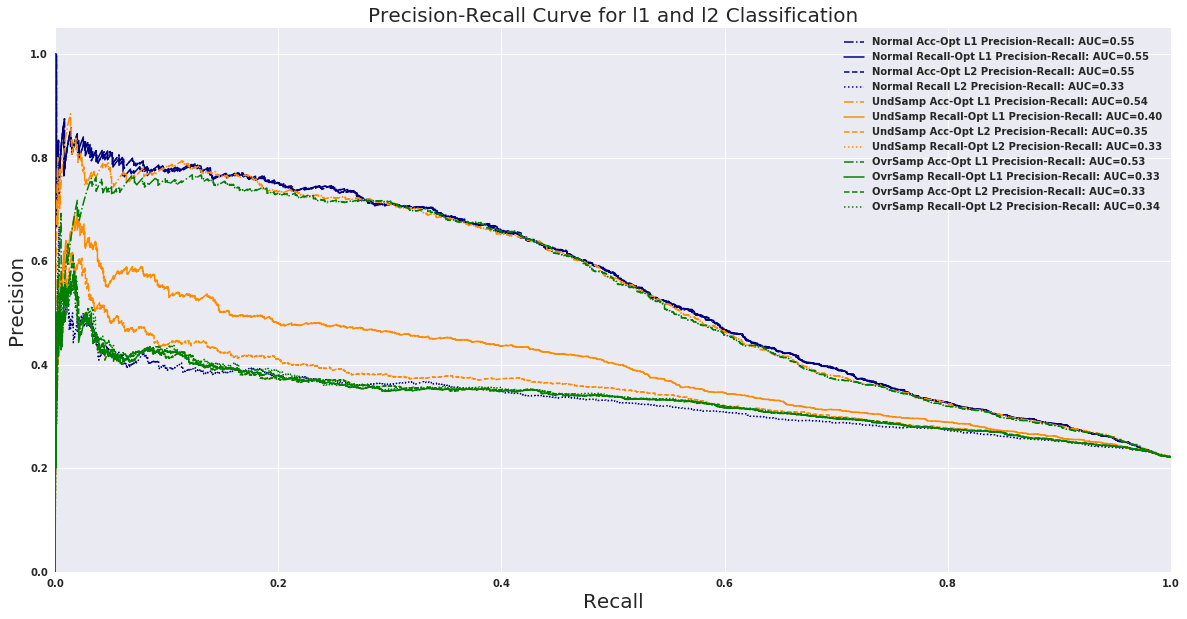

In [93]:
# Plotting all the curves
n_classes = len(defaults_df.Y)

# Here are all of the models and their scores
#regular
y_score_1 = clf_opt_accuracy_L1.decision_function(Xtest) #id1_accuracy_optimized_normal_l1
y_score_2 = clf_opt_recall_L1.decision_function(Xtest)   #id2_recall_optimized_normal_l1
y_score_3 = clf_opt_accuracy_L1.decision_function(Xtest) #id3_accuracy_optimized_normal_l2
y_score_4 = clf_opt_recall_L2.decision_function(Xtest)   #id4_recall_optimized_normal_l2
#undersampled
y_score_5 = clf_under_smpld_accur_l1.decision_function(Xtest)   #id5_under_accuracy_optimized_normal_l1
y_score_6 = clf_under_smpld_recall_l1.decision_function(Xtest)  #id6_under_recall_optimized_normal_l1
y_score_7 = clf_under_smpld_accur_l2.decision_function(Xtest)   #id7_under_accuracy_optimized_normal_l2
y_score_8 = clf_under_smpld_recall_l2.decision_function(Xtest)  #id8_under_recall_optimized_normal_l2
#oversampled
y_score_9 = clf_over_smpld_accur_l1.decision_function(Xtest) #id9_over_accuracy_optimized_normal_l1
y_score_10 = clf_over_smpld_recall_l1.decision_function(Xtest) #id10_over_recall_optimized_normal_l1
y_score_11 = clf_over_smpld_accur_l2.decision_function(Xtest) #id11_over_accuracy_optimized_normal_l2
y_score_12 = clf_over_smpld_recall_l2.decision_function(Xtest) #id12_over_recall_optimized_normal_l2

# models and precision dictionaries
#regular
precision_1 = dict()
precision_2 = dict()
precision_3 = dict()
precision_4 = dict()
#undersampled
precision_5 = dict()
precision_6 = dict()
precision_7 = dict()
precision_8 = dict()
#oversampled
precision_9 = dict()
precision_10 = dict()
precision_11 = dict()
precision_12 = dict()

# models and recall dictionaries
#regular
recall_1 = dict()
recall_2 = dict()
recall_3 = dict()
recall_4 = dict()
#undersampled
recall_5 = dict()
recall_6 = dict()
recall_7 = dict()
recall_8 = dict()
#oversampled
recall_9 = dict()
recall_10 = dict()
recall_11 = dict()
recall_12 = dict()

#average precisions for all models
#regular
avg_precision_1 = dict()
avg_precision_2 = dict()
avg_precision_3 = dict()
avg_precision_4 = dict()
#undersampled
avg_precision_5 = dict()
avg_precision_6 = dict()
avg_precision_7 = dict()
avg_precision_8 = dict()
#oversampled
avg_precision_9 = dict()
avg_precision_10 = dict()
avg_precision_11 = dict()
avg_precision_12 = dict()

#precision recall curves calculated for all models
#regular
precision_1, recall_1, _ = precision_recall_curve(ytest, y_score_1)
precision_2, recall_2, _ = precision_recall_curve(ytest, y_score_2)
precision_3, recall_3, _ = precision_recall_curve(ytest, y_score_3)
precision_4, recall_4, _ = precision_recall_curve(ytest, y_score_4)
#undersampled
precision_5, recall_5, _ = precision_recall_curve(ytest, y_score_5)
precision_6, recall_6, _ = precision_recall_curve(ytest, y_score_6)
precision_7, recall_7, _ = precision_recall_curve(ytest, y_score_7)
precision_8, recall_8, _ = precision_recall_curve(ytest, y_score_8)
#oversampled
precision_9, recall_9, _ = precision_recall_curve(ytest, y_score_9)
precision_10, recall_10, _ = precision_recall_curve(ytest, y_score_10)
precision_11, recall_11, _ = precision_recall_curve(ytest, y_score_11)
precision_12, recall_12, _ = precision_recall_curve(ytest, y_score_12)
    
#Plot average precision for all models
#regular
avg_precision_1 = average_precision_score(ytest, y_score_1)
avg_precision_2 = average_precision_score(ytest, y_score_2)
avg_precision_3 = average_precision_score(ytest, y_score_3)
avg_precision_4 = average_precision_score(ytest, y_score_4)
#undersampled
avg_precision_5 = average_precision_score(ytest, y_score_5)
avg_precision_6 = average_precision_score(ytest, y_score_6)
avg_precision_7 = average_precision_score(ytest, y_score_7)
avg_precision_8 = average_precision_score(ytest, y_score_8)
#oversampled
avg_precision_9 = average_precision_score(ytest, y_score_9)
avg_precision_10 = average_precision_score(ytest, y_score_10)
avg_precision_11 = average_precision_score(ytest, y_score_11)
avg_precision_12 = average_precision_score(ytest, y_score_12)

#score
#precision dict
#recall dict
#average precision
#calc precision recall curves

# Plot Precision-Recall curve
plt.figure(figsize=(20,10))

plt.clf()
lw=1.5
plt.plot(recall_1, precision_1, lw=lw, color='navy', linestyle='dashdot',
         label='Normal Acc-Opt L1 Precision-Recall: AUC={0:0.2f}'.format(avg_precision_1))
plt.plot(recall_2, precision_2, lw=lw, color='navy', linestyle='solid',
         label='Normal Recall-Opt L1 Precision-Recall: AUC={0:0.2f}'.format(avg_precision_2))
plt.plot(recall_3, precision_3, lw=lw, color='navy', linestyle='dashed',
         label='Normal Acc-Opt L2 Precision-Recall: AUC={0:0.2f}'.format(avg_precision_3))
plt.plot(recall_4, precision_4, lw=lw, color='navy', linestyle='dotted',
         label='Normal Recall L2 Precision-Recall: AUC={0:0.2f}'.format(avg_precision_4))

plt.plot(recall_5, precision_5, lw=lw, color='darkorange', linestyle='dashdot',
         label='UndSamp Acc-Opt L1 Precision-Recall: AUC={0:0.2f}'.format(avg_precision_5))
plt.plot(recall_6, precision_6, lw=lw, color='darkorange', linestyle='solid',
         label='UndSamp Recall-Opt L1 Precision-Recall: AUC={0:0.2f}'.format(avg_precision_6))
plt.plot(recall_7, precision_7, lw=lw, color='darkorange', linestyle='dashed',
         label='UndSamp Acc-Opt L2 Precision-Recall: AUC={0:0.2f}'.format(avg_precision_7))
plt.plot(recall_8, precision_8, lw=lw, color='darkorange', linestyle='dotted',
         label='UndSamp Recall-Opt L2 Precision-Recall: AUC={0:0.2f}'.format(avg_precision_8))

plt.plot(recall_9, precision_9, lw=lw, color='g', linestyle='dashdot',
         label='OvrSamp Acc-Opt L1 Precision-Recall: AUC={0:0.2f}'.format(avg_precision_9))
plt.plot(recall_10, precision_10, lw=lw, color='g', linestyle='solid',
         label='OvrSamp Recall-Opt L1 Precision-Recall: AUC={0:0.2f}'.format(avg_precision_10))
plt.plot(recall_11, precision_11, lw=lw, color='g', linestyle='dashed',
         label='OvrSamp Acc-Opt L2 Precision-Recall: AUC={0:0.2f}'.format(avg_precision_11))
plt.plot(recall_12, precision_12, lw=lw, color='g', linestyle='dotted',
         label='OvrSamp Recall-Opt L2 Precision-Recall: AUC={0:0.2f}'.format(avg_precision_12))


plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for l1 and l2 Classification', fontsize=20)
plt.legend(loc=1)
plt.show()

## A remark on re-sampling techniques
Well, one interesting point is that I have done some hyptohesis testing to determine that education level determines if there is a higher likelihood of defaulting on the next month's payment. That said, it may make sense to use a KNN implementation, such as 'TomekLink' which groups close neighbors as the minor class. This also goes back to the original point that the probability of default at this time is arbitrary on when we chose to classify. We may have missed a unique default the month before or after. Combining close neighbors and the arbitrariness of the predictions, it may be better to use a KNN method to classify points. 